<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
from keras import backend as K
import pandas as pd
import seaborn as sns

2024-11-23 11:52:59.069699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 11:53:03.953224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732359185.563558 2033009 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732359186.080533 2033009 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 11:53:10.341659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

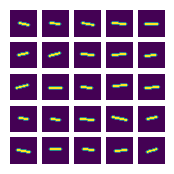

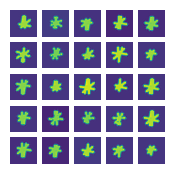

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates (num x 2 array of btwn 12 & 16)
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images 
        # cv2.line(image, start_point, end_point, color, thickness, linetype) 
        # Use (y,x) instead of (x,y) for horizontal line
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='*'))

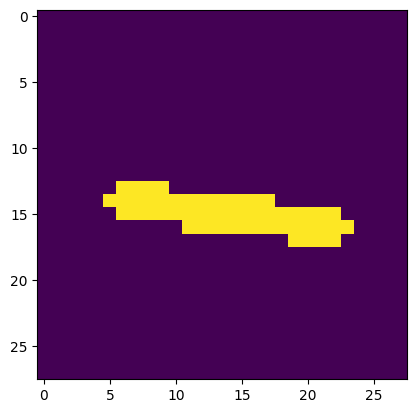

In [3]:
import numpy as np
import cv2
# Creating a black screen image using numpy.zeros function
Img = np.zeros((28, 28), dtype='uint8')
start_point = (6, 14) 
end_point = (22, 16)
image = cv2.line(Img, start_point, end_point, color = (255, 250, 255), thickness = 2)
plt.imshow(image)
plt.show()

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)] # Get indices of labels that match each labels in a 10xn array
    num_data = [MNIST_data[inds] for inds in num_indices] # Get the number data
    image_mapping = dict(zip(unique_characters[:10], num_data)) #unique_char = '0123456789+- ', [:10] is 0 to 9 (string form)
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                # data is created as i +/- j e.g [0]: 0+0, [1]:0-0, [2]:0+1, [3]:0-1
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char] 
                    index = np.random.randint(0, len(image_set), 1) #random char image from set
                    query_image.append(image_set[index].squeeze()) #squeeze remove useless dim e.g (1.3,3) to (3,3)

                result = eval(query_string) # python function to evaluate string as number as int/float
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7873

X_text: "39-36" = y_text: "3  "


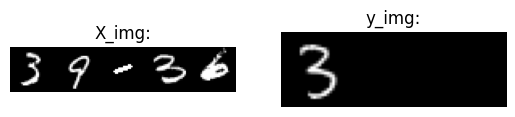

Query #18945

X_text: "94-72" = y_text: "22 "


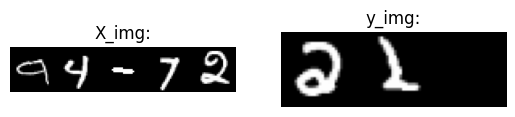

Query #15403

X_text: "77-1 " = y_text: "76 "


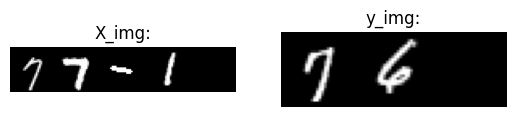

Query #200

X_text: "1+0  " = y_text: "1  "


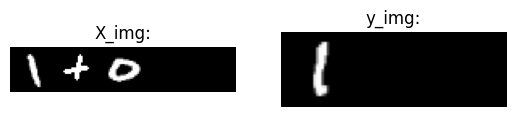

Query #11605

X_text: "58-2 " = y_text: "56 "


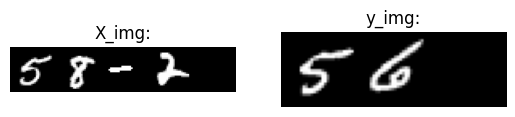

Query #18681

X_text: "93-40" = y_text: "53 "


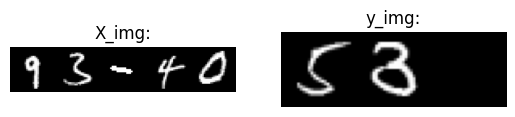

Query #11544

X_text: "57+72" = y_text: "129"


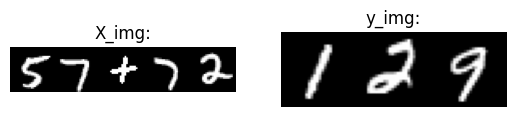

Query #7755

X_text: "38-77" = y_text: "-39"


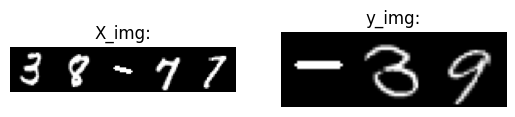

Query #506

X_text: "2+53 " = y_text: "55 "


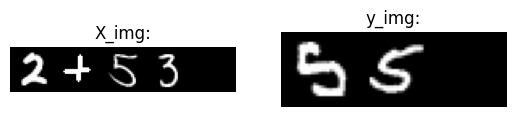

Query #16845

X_text: "84-22" = y_text: "62 "


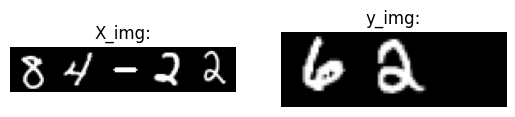

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data() #60000 data
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 20000, 1)[0]) #randomly select

Query #1

X_text: "0-0  " = y_text: "0  "


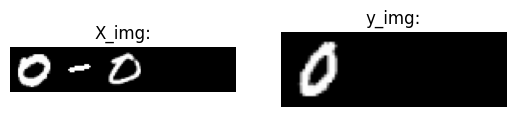

In [52]:
display_sample(1)


## Helper functions

The functions below will help with input/output of the data.

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3): #encode string to numeric array: 0-9 as 0-9, -,+,' ' as 10,11,12| based on unique_characters = '0123456789+- ' 
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


In [161]:
print(X_text_onehot[2])
decode_labels(X_text_onehot[2])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


'0+1  '

---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [144]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [58]:
X_text


array(['0+0  ', '0-0  ', '0+1  ', ..., '99-98', '99+99', '99-99'],
      dtype='<U5')

In [145]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text
his_t2t = []
t2t_model_l = []
split = [0.2,0.5,0.75,0.9]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_text_onehot, test_size=split[i], random_state=42)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2t_model = build_text2text_model()
    his_t2t.append(t2t_model.fit(train_x, train_y,
                                 epochs = 50,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 0))
    t2t_model_l.append(t2t_model)



/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

125/125 - 0s - 793us/step - accuracy: 0.9197 - loss: 0.2550
313/313 - 0s - 746us/step - accuracy: 0.9225 - loss: 0.2040
469/469 - 0s - 675us/step - accuracy: 0.9258 - loss: 0.2277
563/563 - 0s - 614us/step - accuracy: 0.6208 - loss: 1.0445


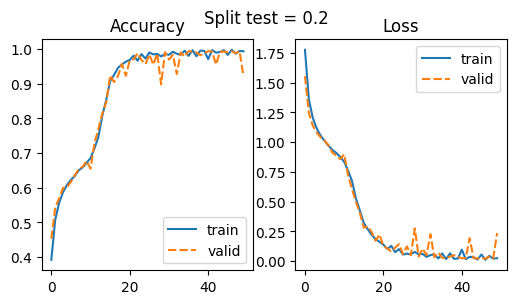

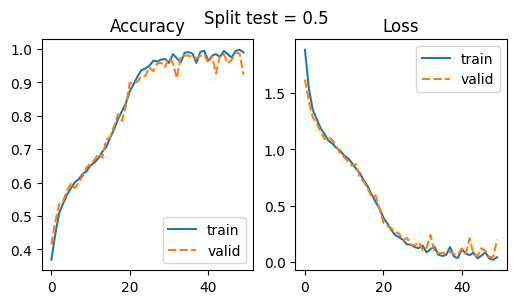

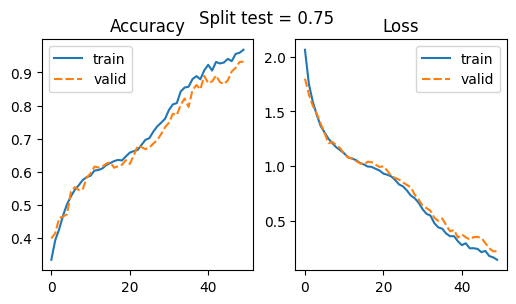

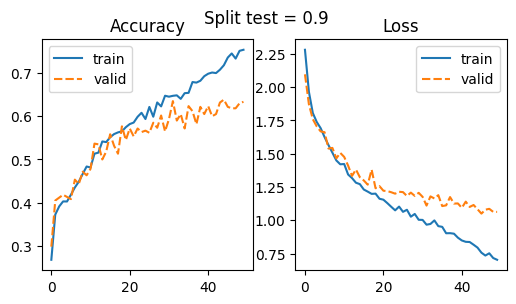

In [146]:
n1 = len(split)
for i in range(n1):
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    acc_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    acc_df['train'] = his_t2t[i].history['accuracy']
    acc_df['valid'] = his_t2t[i].history['val_accuracy']
    loss_df['train'] = his_t2t[i].history['loss']
    loss_df['valid'] = his_t2t[i].history['val_loss']
    sns.lineplot(acc_df,ax=axs[0]).set_title("Accuracy")
    sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    t2t_model_l[i].evaluate(data_split[i][1],  data_split[i][3], verbose=2)

In [195]:
for i in range(n1):
    pred = t2t_model_l[i].predict(data_split[i][1][:2])
    # print(np.argmax(pred,axis=2))
    # print(np.argmax(pred,axis=2).shape)
    one_hot_predictions = np.zeros_like(pred)
    np.put_along_axis(one_hot_predictions, np.argmax(pred, axis=-1)[..., np.newaxis], 1, axis=-1)
    # print(one_hot_predictions)  # Output: (10, 5, 13)
    print("-"*24)
    print(f"Split test = {split[i]}")
    print("-"*24)
    for j in range(len(one_hot_predictions)):
        print(f"Q{j+1}: {decode_labels(data_split[i][1][j])}")
        print(f"Pred: {decode_labels(one_hot_predictions[j])}")
        print(f"Ans: {decode_labels(data_split[i][3][j])}")
        print("#"*24)
    



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


------------------------
Split test = 0.2
------------------------
Q1: 53+25
Pred: 79 
Ans: 78 
########################
Q2: 10-20
Pred: -10
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
------------------------
Split test = 0.5
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -10
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
------------------------
Split test = 0.75
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -1 
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
------------------------
Split test = 0.9
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -6 
Ans: -10
########################



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
## Your code
def build_image2text_model():

    # We start by initializing a sequential model
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(5, 28, 28)))
    model.add(tf.keras.layers.Reshape(target_shape=(5,28,28,1)))
    # model.add(tf.keras.layers.Rescaling(1./255))
    
    #encode
    model.add(ConvLSTM2D(4,(3,3),
                         activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01),
                         padding="same",
                         return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256,kernel_regularizer=tf.keras.regularizers.l2(0.05)))
    
    #Decode
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(64, return_sequences= True))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  metrics=['accuracy'])
    model.summary()

    return model




In [ ]:
t2i_model = build_image2text_model()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 5, 28, 28, 4)   │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 28, 28, 4)   │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 784)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │       217,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 13)          │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,965 (984.24 KB)

 Trainable params: 251,957 (984.21 KB)

 Non-trainable params: 8 (32.00 B)

In [310]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

his_i2t = []
i2t_model_l = []
split = [0.5]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_img, y_text_onehot, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    i2t_model = build_image2text_model()
    his_i2t.append(i2t_model.fit(train_x, train_y,
                                 epochs = 150,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping,reduce_lr]))
    i2t_model_l.append(i2t_model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 28, 28, 4)   │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 28, 28, 4)   │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 784)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     1,065,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149,757 (4.39 MB)

 Trainable params: 1,149,749 (4.39 MB)

 Non-trainable params: 8 (32.00 B)

Epoch 1/150


E0000 00:00:1732377650.916176 2033009 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_2', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_54/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/Statefu

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2863 - loss: 11.2588 - val_accuracy: 0.3063 - val_loss: 2.1106 - learning_rate: 0.0010
Epoch 2/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3792 - loss: 2.0003 - val_accuracy: 0.3737 - val_loss: 2.0100 - learning_rate: 0.0010
Epoch 3/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3901 - loss: 1.9626 - val_accuracy: 0.3930 - val_loss: 1.9490 - learning_rate: 0.0010
Epoch 4/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3890 - loss: 1.9430 - val_accuracy: 0.3973 - val_loss: 1.8840 - learning_rate: 0.0010
Epoch 5/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3954 - loss: 1.9223 - val_accuracy: 0.4023 - val_loss: 1.8639 - learning_rate: 0.0010
Epoch 6/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3927 - loss: 1.9091 - val_accuracy: 0.4013 - val_loss: 1.8913 - learning_rate: 0.0010
Epoch 7/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3982 - loss: 1.8913 - val_

313/313 - 1s - 2ms/step - accuracy: 0.5518 - loss: 1.3222


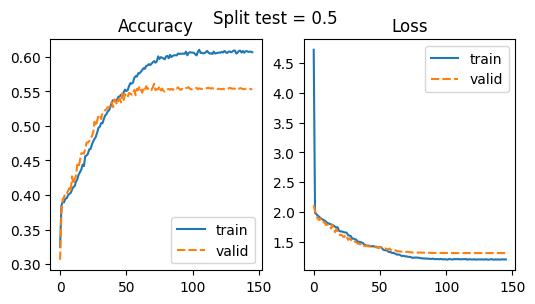

In [312]:
n1 = len(split)
for i in range(n1):
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    acc_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    acc_df['train'] = his_i2t[i].history['accuracy']
    acc_df['valid'] = his_i2t[i].history['val_accuracy']
    loss_df['train'] = his_i2t[i].history['loss']
    loss_df['valid'] = his_i2t[i].history['val_loss']
    sns.lineplot(acc_df,ax=axs[0]).set_title("Accuracy")
    sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    i2t_model_l[i].evaluate(data_split[i][1],  data_split[i][3], verbose=2)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Dense, Flatten, LSTM, Embedding, TimeDistributed, Reshape, RepeatVector

K.clear_session()
class expand_d(tf.keras.Layer):
    def call(self, x):
        return tf.expand_dims(x, axis=1)


# Define model
input_shape = (5, 28, 28)  # Sequence of 5 images, 28x28 each

inputs = Input(shape=input_shape)
inputs = Reshape((5,28,28,1))(inputs)

# ConvLSTM2D to process image sequences
x = ConvLSTM2D(32, (3, 3), return_sequences=False, padding='same')(inputs)
x = Flatten()(x)

# Fully connected layer
x = Dense(128, activation='relu')(x)

# Recurrent layer for sequence prediction
x = expand_d()(x)  # Add time dimension for LSTM
x = LSTM(64)(x)
x = RepeatVector(max_answer_length)(x)
# TimeDistributed Dense layer for each character in output
outputs = TimeDistributed(Dense(13, activation='softmax'))(x)

# Build model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_x, train_y, epochs=10, batch_size=32, 
                    validation_split = 0.1)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE             │ (None, 5, 28, 28, 1)   │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 28, 28, 32)     │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_d (expand_d)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,299,789 (12.59 MB)

 Trainable params: 3,299,789 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


E0000 00:00:1732365343.758692 2033009 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/StatefulPartitionedCall/functional_1/conv_lstm2d_1/zeros_1_switch/_120-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/StatefulPartitionedCall/functional_1/conv_lstm2d_1/zeros_1_switch/_120', 'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/body/_42/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1' -> 'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/body/_42/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/body/_42/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'StatefulPartitionedCall/functional_1/conv_lstm2d_1/while/body/_42/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_2', 'StatefulPartitio

282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2138 - loss: 2.3732 - val_accuracy: 0.2703 - val_loss: 2.2639
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2788 - loss: 2.2449 - val_accuracy: 0.2900 - val_loss: 2.2324
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3086 - loss: 2.1830 - val_accuracy: 0.2877 - val_loss: 2.2379
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3200 - loss: 2.1308 - val_accuracy: 0.3050 - val_loss: 2.2066
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3366 - loss: 2.0494 - val_accuracy: 0.2963 - val_loss: 2.2289
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3519 - loss: 1.9435 - val_accuracy: 0.2913 - val_loss: 2.2716
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3664 - loss: 1.8105 - val_accuracy: 0.2673 - val_loss: 2.3094
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3733 - loss: 1.6785 - val_accuracy: 0.258

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [293]:
# Your code
def build_text2image_model():
    model = tf.keras.Sequential()
    #Encode
    model.add(LSTM(256, input_shape=(None, len(unique_characters))))
    #Decode
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    
    model.add(TimeDistributed(Dense(4 * 4 * 64, activation='sigmoid')))
    model.add(Reshape((3, 4, 4, 64)))
    model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))

    
    # This last convolutional layer converts back to a channel RGB image
    # model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(5,5), activation='sigmoid')))
    
    model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), activation='relu')))
    model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid')))

    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.summary()

    return model

In [108]:
y_img[1].shape

(3, 28, 28)

In [294]:
t2i_model = build_text2image_model()

/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 1024)        │        14,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 8, 8, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 16, 16, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 32, 32, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 3, 30, 30, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 3, 28, 28, 1)   │            10 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,189,656 (4.54 MB)

 Trainable params: 1,189,656 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [295]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

his_t2i = []
t2i_model_l = []
split = [0.2]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i_model = build_text2image_model()
    his_t2i.append(t2i_model.fit(train_x, train_y,
                                 epochs = 10,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping]))
    t2i_model_l.append(t2i_model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 1024)        │        14,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 8, 8, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 16, 16, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 32, 32, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 30, 30, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 28, 28, 1)   │            10 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,189,656 (4.54 MB)

 Trainable params: 1,189,656 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.2780 - val_loss: 0.2211
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2225 - val_loss: 0.2203
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2212 - val_loss: 0.2201
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2219 - val_loss: 0.2201
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2219 - val_loss: 0.2200
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2214 - val_loss: 0.2208
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2212 - val_loss: 0.2203
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2218 - val_loss: 0.2205
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2219 - val_loss: 0.2202
Epoch 10/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2210 - val_loss: 0.2201


In [208]:
data_split[0][1].shape
data_split[0][3].shape

(4000, 3, 28, 28)

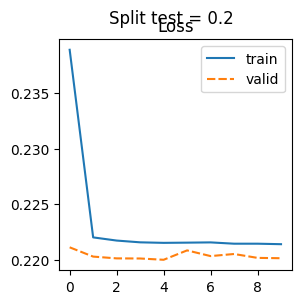

In [296]:
n1 = len(split)
for i in range(n1):
    fig, axs = plt.subplots(figsize=(3,3))
    loss_df = pd.DataFrame()
    loss_df['train'] = his_t2i[i].history['loss']
    loss_df['valid'] = his_t2i[i].history['val_loss']
    sns.lineplot(loss_df).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    # t2i_model_l[i].evaluate(data_split[i][1],  data_split[i][3], verbose=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Q0: 48-97


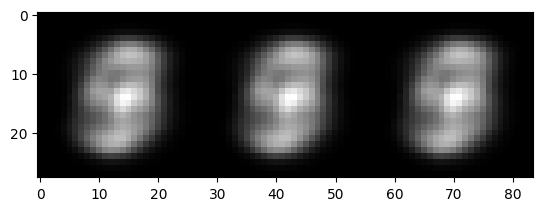

Q1: 37-50


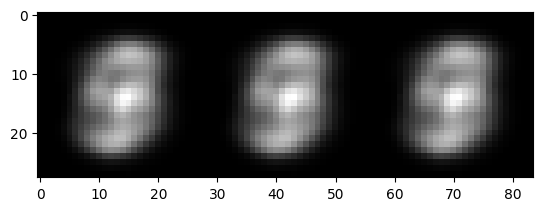

Q2: 94+66


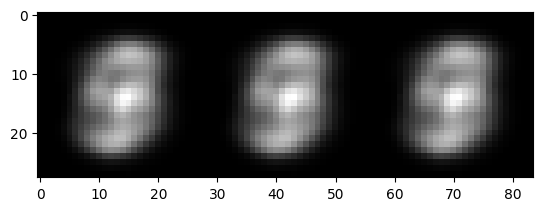

In [245]:
n2 = 3
for i in range(n1):
    pred = t2i_model_l[i].predict(data_split[i][1][:n2])
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split[i][1][j])}")
        plt.imshow(pred_img,cmap='gray')
        plt.show()

In [289]:
from tensorflow.keras import layers, Model

def build_improved_text2image_model():
    # Input Shape: (3, 13) -> Example: text input
    encoder_input = layers.Input(shape=(None, len(unique_characters)))
    
    # Encoder: LSTM
    encoder_output = layers.LSTM(256, return_state=False)(encoder_input)
    
    # Repeat vector for sequence generation
    decoder_input = layers.RepeatVector(max_answer_length)(encoder_output)
    
    # Decoder LSTM
    x = layers.LSTM(256, return_sequences=True)(decoder_input)
    
    # Fully Connected Layer to match initial spatial dimensions (4 × 4 × 64)
    x = layers.TimeDistributed(layers.Dense(4 * 4 * 64, activation='sigmoid'))(x)
    x = layers.Reshape((max_answer_length, 4, 4, 64))(x)  # Shape: (max_answer_length, 4, 4, 64)
    
    # Convolutional Upsampling
    x = layers.TimeDistributed(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x)  # 4x4 -> 8x8
    x = layers.TimeDistributed(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x)   # 8x8 -> 16x16
    x = layers.TimeDistributed(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x)
    
    # Final Upsampling to 28x28
    x = layers.TimeDistributed(layers.Conv2D(1, (5, 5), strides=(1, 1), padding='valid', activation='sigmoid'))(x)  # 16x16 -> 28x28

    # Model Compilation
    model = Model(encoder_input, x, name="text2image_28x28")
    model.compile(optimizer='adam', loss='mse')  # Use MSE or an alternative loss
    model.summary()
    return model


In [290]:
build_improved_text2image_model()

Model: "text2image_28x28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, None, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_23 (RepeatVector) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_96             │ (None, 3, 1024)        │       263,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 3, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_97             │ (None, 3, 8, 8, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_98             │ (None, 3, 16, 16, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_99             │ (None, 3, 32, 32, 64)  │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_100            │ (None, 3, 28, 28, 1)   │         1,601 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,137 (4.77 MB)

 Trainable params: 1,251,137 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=text2image_28x28, built=True>

Model: "text2image_28x28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 1024)        │       263,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 8, 8, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 16, 16, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 32, 32, 64)  │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 28, 28, 1)   │         1,601 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251,137 (4.77 MB)

 Trainable params: 1,251,137 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0873 - val_loss: 0.0793
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0802 - val_loss: 0.0793
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0806 - val_loss: 0.0793
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0800 - val_loss: 0.0793
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0802 - val_loss: 0.0793
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0805 - val_loss: 0.0793
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0802 - val_loss: 0.0793
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0803 - val_loss: 0.0793
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0802 - val_loss: 0.0793
Epoch 10/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0804 - val_loss: 0.0793


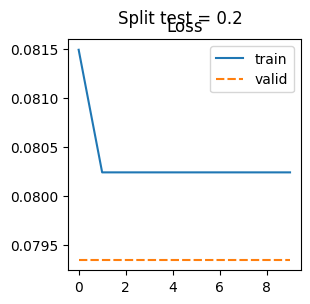

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Q0: 48-97


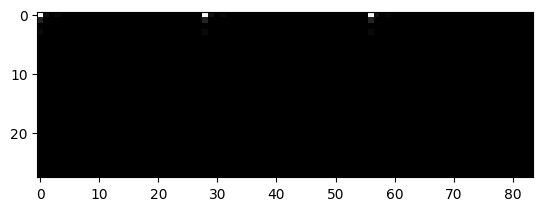

Q1: 37-50


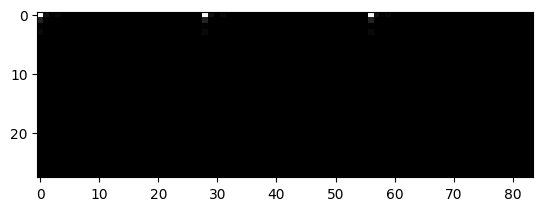

In [292]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

his_t2i2 = []
t2i2_model_l = []
split = [0.2]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i2_model = build_improved_text2image_model()
    his_t2i2.append(t2i2_model.fit(train_x, train_y,
                                 epochs = 10,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping]))
    t2i2_model_l.append(t2i2_model)
n1 = len(split)
n2 = 2
for i in range(n1):
    fig, axs = plt.subplots(figsize=(3,3))
    loss_df = pd.DataFrame()
    loss_df['train'] = his_t2i2[i].history['loss']
    loss_df['valid'] = his_t2i2[i].history['val_loss']
    sns.lineplot(loss_df).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    plt.show()
    pred = t2i2_model_l[i].predict(data_split[i][1][:n2])
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split[i][1][j])}")
        plt.imshow(pred_img,cmap='gray')
        plt.show()